In [1]:
from fastai.vision import *
import seaborn as sns
from matplotlib.pyplot import figure
import torch
import os

In [2]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [3]:
torch.cuda.is_available()

True

In [2]:
PATH = '/home/jupyter/tutorials/data/9-25 test'

# 1. EDA 

In [5]:
df = pd.read_csv(f'{PATH}/filename.csv')

In [6]:
df.tail(10)

,filenames,tags
2016,unsafe_tv unsafe_furniture (66).jpg,unsafe_tv unsafe_furniture
2017,unsafe_tv unsafe_furniture (67).jpg,unsafe_tv unsafe_furniture
2018,unsafe_tv unsafe_furniture (68).jpg,unsafe_tv unsafe_furniture
2019,unsafe_tv unsafe_furniture (69).jpg,unsafe_tv unsafe_furniture
2020,unsafe_tv unsafe_furniture (7).JPEG,unsafe_tv unsafe_furniture
2021,unsafe_tv unsafe_furniture (7).jpg,unsafe_tv unsafe_furniture
2022,unsafe_tv unsafe_furniture (8).JPEG,unsafe_tv unsafe_furniture
2023,unsafe_tv unsafe_furniture (8).jpg,unsafe_tv unsafe_furniture
2024,unsafe_tv unsafe_furniture (9).JPEG,unsafe_tv unsafe_furniture
2025,unsafe_tv unsafe_furniture (9).jpg,unsafe_tv unsafe_furniture


Text(0.5, 1.0, 'Unsafe TV')

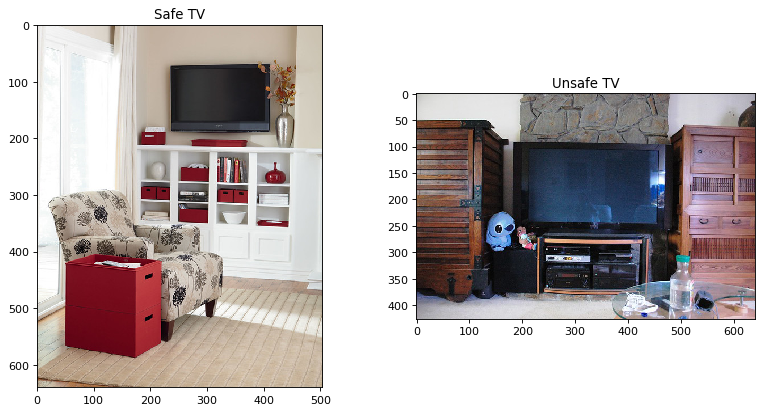

In [7]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
img = plt.imread('/home/jupyter/tutorials/data/9-25 test/safe_tv  (70).jpg') ; plt.imshow(img)
plt.title('Safe TV')
plt.subplot(1,2,2)
img_1 = plt.imread('/home/jupyter/tutorials/data/9-25 test/unsafe_tv (194).jpg') ; plt.imshow(img_1)
plt.title('Unsafe TV')

Text(0.5, 1.0, 'Unsafe Kitchen')

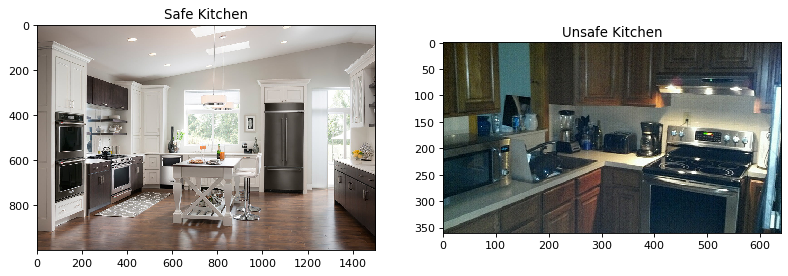

In [8]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
img = plt.imread('/home/jupyter/tutorials/data/9-25 test/safe_kitchen (201).jpg') ; plt.imshow(img)
plt.title('Safe Kitchen')
plt.subplot(1,2,2)
img_1 = plt.imread('/home/jupyter/tutorials/data/9-25 test/unsafe_kitchen (98).jpg') ; plt.imshow(img_1)
plt.title('Unsafe Kitchen')

Text(0.5, 1.0, 'Unsafe Furniture')

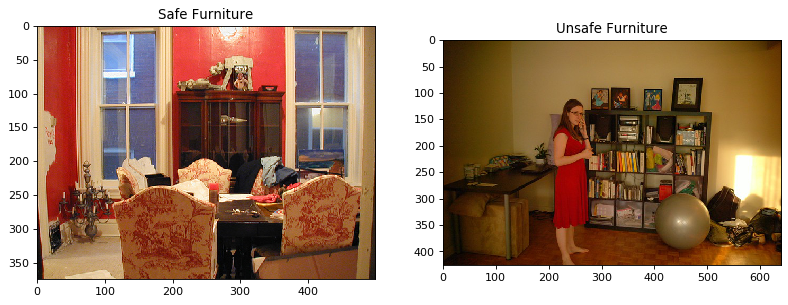

In [9]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
img = plt.imread('/home/jupyter/tutorials/data/9-25 test/safe_furniture  (199).JPEG') ; plt.imshow(img)
plt.title('Safe Furniture')
plt.subplot(1,2,2)
img_1 = plt.imread('/home/jupyter/tutorials/data/9-25 test/unsafe_furniture (100).jpg') ; plt.imshow(img_1)
plt.title('Unsafe Furniture')

The Multi-Labeled Classes with two-outputs:

Text(0.5, 1.0, 'Unsafe TV + Safe Furniture')

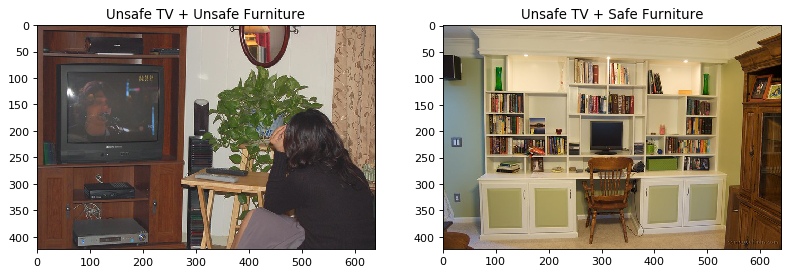

In [10]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
img = plt.imread('/home/jupyter/tutorials/data/9-25 test/unsafe_tv unsafe_furniture (63).jpg') ; plt.imshow(img)
plt.title('Unsafe TV + Unsafe Furniture')
plt.subplot(1,2,2)
img_1 = plt.imread('/home/jupyter/tutorials/data/9-25 test/unsafe_tv safe_furniture  (26).jpg') ; plt.imshow(img_1)
plt.title('Unsafe TV + Safe Furniture')

In [11]:
df.tags.value_counts()

safe_kitchen                  488
unsafe_kitchen                401
unsafe_tv                     302
unsafe_furniture              279
safe_tv                       213
safe_furniture                210
unsafe_tv unsafe_furniture     78
unsafe_tv safe_furniture       55
Name: tags, dtype: int64

In [12]:
len(df.tags)

2026

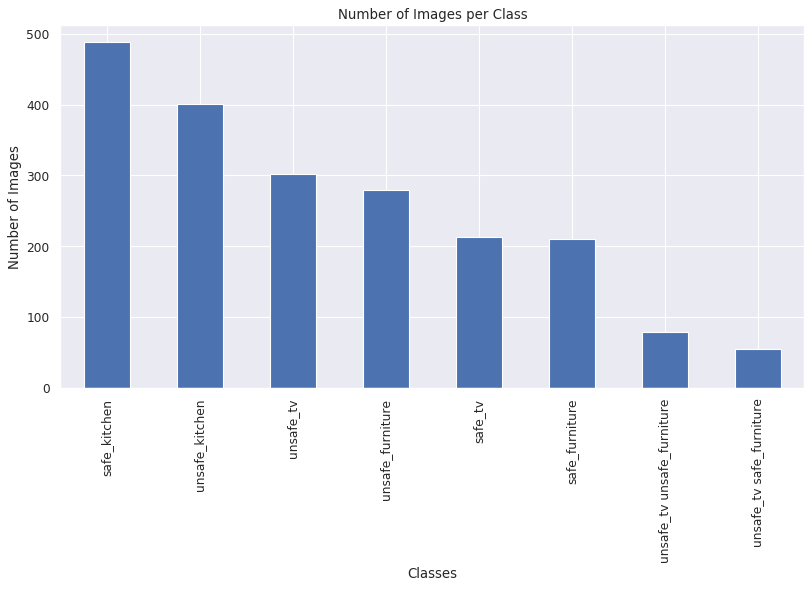

In [8]:
sns.set()
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Number of Images per Class')
plt.ylabel('Number of Images')
plt.xlabel('Classes')
df.tags.value_counts().plot.bar()

# 2. Modeling

In [3]:
tfms = get_transforms(flip_vert=False, max_zoom=1.3,max_warp=0.4, max_lighting=0)

In [4]:
np.random.seed(369)
src = (ImageList.from_csv(PATH, 'filename.csv', folder='')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [5]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

In [8]:
data.classes

['safe_furniture',
 'safe_kitchen',
 'safe_tv',
 'unsafe_furniture',
 'unsafe_kitchen',
 'unsafe_tv']

The multi labeled classes are separated by ';'

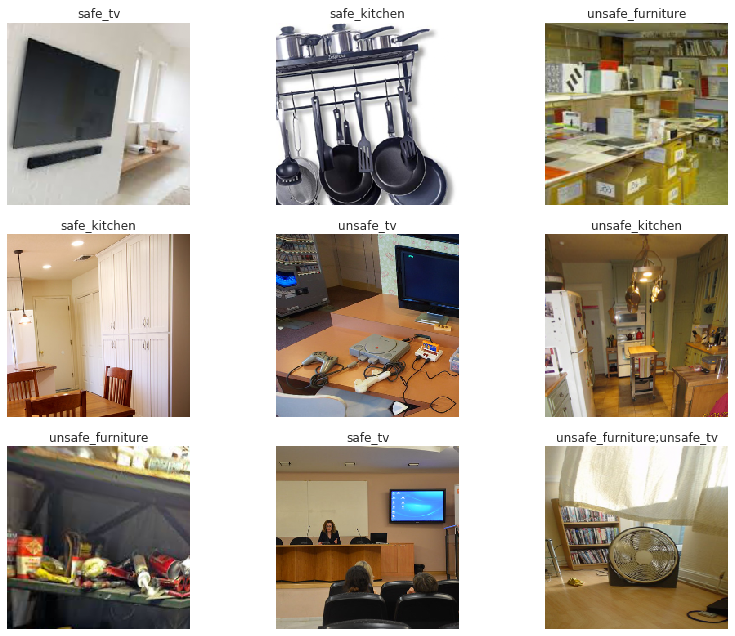

In [13]:
data.show_batch(rows=3, figsize=(12,9))

In [22]:
import sys
from PIL import Image

if len(sys.argv) < 2:
    print("Error : Too Few Arguments \nUsage : python del_unwanted.py $1 \nwhere $1 = \"dir_name\" ( where images are stored ) \nRequires absolute directory path")
    sys.exit()
dirname=sys.argv[1]
cnt=0
for filename in os.listdir(PATH):
    try:
        img=Image.open(PATH+"/"+filename)
    except OSError:
        print("FILE: ", filename, "is corrupt!")
        cnt+=1
        os.remove(PATH+"/"+filename)
print("Successfully Completed Operation! Files Courrupted are ", cnt)

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2703: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


FILE:  unsafe_kitchen (154).jpg is corrupt!
FILE:  unsafe_kitchen (134).jpg is corrupt!
FILE:  unsafe_kitchen (175).jpg is corrupt!
FILE:  unsafe_kitchen (215).jpg is corrupt!
FILE:  filename.csv is corrupt!
FILE:  unsafe_kitchen (157).jpg is corrupt!
FILE:  unsafe_tv (281).jpg is corrupt!
FILE:  unsafe_kitchen (115).jpg is corrupt!
FILE:  unsafe_kitchen (116).jpg is corrupt!
Successfully Completed Operation! Files Courrupted are  9


Defining Accuracy Thresh + F-Score, with threhold of 0.2. A high Recall Model for Multi Labeling.

In [6]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score])

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


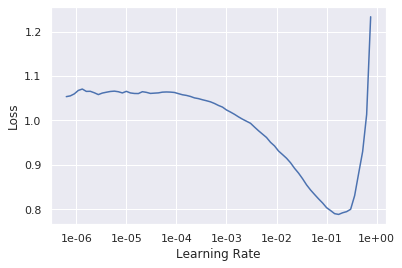

In [21]:
learn.recorder.plot()

## 2.1 Base Model

In [15]:
learn.fit_one_cycle(20, (1e-02+1e-03)/2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.907906,0.592680,0.416049,0.601049,00:19
1,0.790086,0.471412,0.592593,0.685836,00:16
2,0.656567,0.327944,0.695885,0.738787,00:16
3,0.508810,0.202328,0.885597,0.857486,00:16
4,0.393533,0.171757,0.916872,0.866432,00:16
5,0.313541,0.180277,0.917284,0.853904,00:16
6,0.263482,0.184386,0.912346,0.843153,00:16
7,0.225284,0.160153,0.932922,0.866446,00:17
8,0.196784,0.189182,0.925926,0.844418,00:16
9,0.174544,0.179996,0.918930,0.850030,00:17


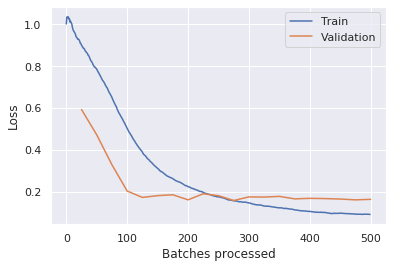

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save('/home/jupyter/m1')

In [7]:
learn_1 = learn.load('/home/jupyter/m1')

## 2.2 Progressive Unfreezing

In [20]:
learn_1.freeze_to(-2)
learn_1.fit_one_cycle(20, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.102579,0.197297,0.923868,0.841817,00:17
1,0.128882,0.479003,0.870370,0.707536,00:16
2,0.166848,0.431822,0.861728,0.672684,00:17
3,0.185212,0.768854,0.815638,0.589822,00:16
4,0.198079,0.340549,0.855556,0.691808,00:17
5,0.201160,0.533065,0.873251,0.728877,00:16
6,0.202492,0.334506,0.879424,0.732462,00:16
7,0.186983,0.300050,0.889300,0.767365,00:17
8,0.184192,0.354588,0.864198,0.717973,00:18
9,0.165855,0.243479,0.895885,0.801158,00:16


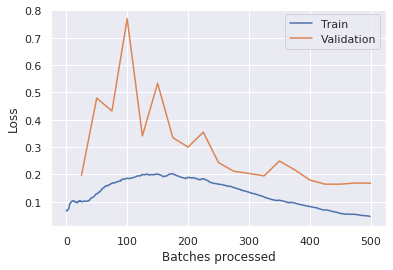

In [23]:
learn_1.recorder.plot_losses()

In [21]:
learn_1.save('/home/jupyter/m1-t02')

In [8]:
learn_1.load('/home/jupyter/m1-t02')

Learner(data=ImageDataBunch;

Train: LabelList (1621 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
safe_furniture,safe_furniture,safe_furniture,safe_furniture,safe_furniture
Path: /home/jupyter/tutorials/data/9-25 test;

Valid: LabelList (405 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
safe_furniture,unsafe_tv,safe_tv,safe_tv,unsafe_kitchen
Path: /home/jupyter/tutorials/data/9-25 test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel

In [24]:
learn_1.freeze_to(-3)
learn_1.fit_one_cycle(20, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.038027,0.184291,0.941152,0.877544,00:16
1,0.045780,0.227496,0.937860,0.858105,00:18
2,0.080366,0.362869,0.900412,0.766168,00:17
3,0.111924,0.388550,0.871193,0.716169,00:17
4,0.133546,0.776075,0.855556,0.657095,00:18
5,0.148956,0.337853,0.872840,0.726922,00:17
6,0.146120,0.266063,0.896708,0.761454,00:17
7,0.140830,0.358325,0.863786,0.675289,00:16
8,0.130964,0.219649,0.916049,0.829372,00:17
9,0.120796,0.228442,0.911111,0.808054,00:17


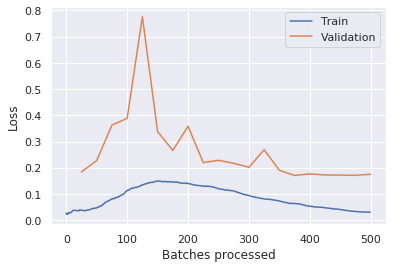

In [27]:
learn_1.recorder.plot_losses()

In [25]:
learn_1.save('/home/jupyter/m1-t03')

In [9]:
learn_1.load('/home/jupyter/m1-t03')

Learner(data=ImageDataBunch;

Train: LabelList (1621 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
safe_furniture,safe_furniture,safe_furniture,safe_furniture,safe_furniture
Path: /home/jupyter/tutorials/data/9-25 test;

Valid: LabelList (405 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
safe_furniture,unsafe_tv,safe_tv,safe_tv,unsafe_kitchen
Path: /home/jupyter/tutorials/data/9-25 test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel

## 2.3 Total Unfreezing

In [10]:
learn_1.unfreeze()

In [11]:
learn_1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.20E-06


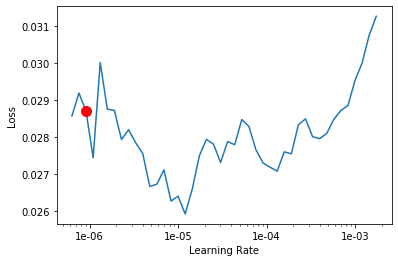

In [12]:
learn_1.recorder.plot(suggestion = True)

In [13]:
learn_1.fit_one_cycle(20, slice(1e-06/(2.6**4),1e-06), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.027001,0.171174,0.943621,0.883432,00:16
1,0.026534,0.171874,0.944033,0.880669,00:15
2,0.024460,0.172682,0.944445,0.881081,00:15
3,0.026053,0.175509,0.944444,0.878905,00:14
4,0.024585,0.169835,0.943621,0.882315,00:15
5,0.024636,0.171672,0.943621,0.878200,00:15
6,0.022843,0.171541,0.943210,0.884490,00:15
7,0.023721,0.173904,0.944856,0.878905,00:15
8,0.027963,0.175506,0.945268,0.879729,00:15
9,0.027767,0.175426,0.943621,0.877671,00:15


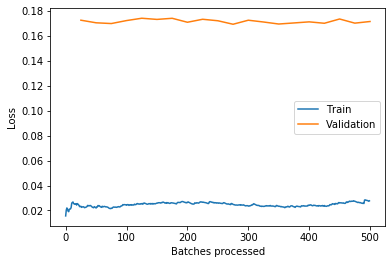

In [19]:
learn_1.recorder.plot_losses()

In [14]:
learn_1.save('/home/jupyter/m1-unfrozen')

In [15]:
learn_1.load('/home/jupyter/m1-unfrozen')

Learner(data=ImageDataBunch;

Train: LabelList (1621 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
safe_furniture,safe_furniture,safe_furniture,safe_furniture,safe_furniture
Path: /home/jupyter/tutorials/data/9-25 test;

Valid: LabelList (405 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
safe_furniture,unsafe_tv,safe_tv,safe_tv,unsafe_kitchen
Path: /home/jupyter/tutorials/data/9-25 test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel

In [16]:
learn_1.freeze()

## 2.4 TTA

In [17]:
learn_1.TTA()

(tensor([[9.4648e-01, 2.0536e-04, 9.0381e-05, 2.0186e-03, 8.1776e-04, 1.2337e-02],
         [6.6840e-02, 1.1609e-02, 2.2027e-03, 1.9100e-02, 1.1025e-01, 8.8908e-01],
         [6.4931e-05, 1.7737e-05, 9.9762e-01, 7.2649e-04, 4.4967e-05, 3.2424e-03],
         ...,
         [4.6989e-04, 1.2472e-02, 9.2062e-01, 1.5790e-03, 2.3237e-03, 9.5714e-02],
         [9.5869e-01, 3.1819e-02, 1.3155e-02, 1.7463e-03, 8.2720e-03, 3.0612e-02],
         [1.0755e-03, 5.2868e-05, 4.0542e-04, 1.0280e-01, 1.4051e-04, 9.9881e-01]]),
 tensor([[1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.]]))

In [21]:
acc_02(*learn_1.TTA(beta=None, scale=1.05, ds_type=DatasetType.Valid))

TypeError: accuracy_thresh() got multiple values for argument 'thresh'

In [30]:
fbeta(*learn_1.TTA(beta=None, scale=1.05, ds_type=DatasetType.Valid))

tensor(0.1098)

## 2.5 MixUp

In [18]:
learn_MixUp = learn_1.to_fp16().mixup(stack_y = False)

In [19]:
learn_MixUp.fit_one_cycle(20, slice(1e-06/(2.6**4),1e-06), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.326673,0.218654,0.935391,0.853236,00:16
1,0.327929,0.216873,0.936625,0.854626,00:14
2,0.330972,0.219847,0.938683,0.856459,00:15
3,0.325011,0.217004,0.937037,0.856165,00:15
4,0.335033,0.226149,0.936214,0.853589,00:16
5,0.335855,0.218210,0.936214,0.853578,00:14
6,0.336160,0.214208,0.936625,0.857693,00:15
7,0.333585,0.211593,0.938683,0.860644,00:14
8,0.333115,0.220763,0.937449,0.856459,00:15
9,0.336046,0.214333,0.936626,0.853990,00:15


The best model was obtained using progressive and then total unfreezing with Discriminative Learning Rate. 

TTA did not work for our model, because mostly of the thresh parameter in our metric function.

MixUp was not really helpful, it made the model underfit by increasing the loss

For the best Accuracy, Beta and Loss scores, please check: https://github.com/fellowship/platform-demos4/blob/master/Childproofing%20from%20Heavyobjects/Heavyobjects_multilabel_finalemodel.ipynb

For Progressive Resizing, please check: https://github.com/fellowship/platform-demos4/blob/master/Childproofing%20from%20Heavyobjects/resizing.ipynb